In [ ]:
!pip install -q transformers trl bitsandbytes peft

In [ ]:
import torch
import pandas as pd
from datasets import load_dataset, Dataset
from transformers import TrainingArguments, AutoTokenizer, AutoModelForCausalLM
from trl import SFTTrainer, SFTConfig
from peft import LoraConfig, get_peft_model

import pandas as pd
import re

USE_GPU = False

In [22]:
PROMPT = """
### Context
{context}

### Instructions
Answer the question **using only the context above**.

### Output Format
Return a valid JSON object in the following format:
{{
  "text": ["<exact answer span from the context>"]
}}

Rules:
- Do not add explanations or extra fields.

### Question
{question}
"""

In [128]:
def generate_responses_logits(model, tokenizer, user_message, system_message=None,
                       max_new_tokens=200, temperature=1.0):
    # Format chat using tokenizer's chat template
    messages = []
    # Add a strong system message to force the output format
    system_message = "You are a helpful assistant. Your task is to answer the questin given the context. Do not provide any other explanations, or reasoning. Only output the answer."
    messages.append({"role": "system", "content": system_message})

    # We assume the data are all single-turn conversation
    messages.append({"role": "user", "content": user_message})

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=False,
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)


    # Recommended to use vllm, sglang or TensorRT
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens, # Limiting max_new_tokens to encourage concise output
            # do_sample=False,
            # num_beams=1,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            # force_words_ids=force_words_ids,
            trust_remote_code=True, # Add this line to resolve the error
            output_scores=True, # <--- Added for logits
            return_dict_in_generate=True # <--- Added to return a dictionary

        )
    input_len = inputs["input_ids"].shape[1]
    generated_ids = outputs.sequences[0][input_len:] # Access sequences from outputs object
    response = tokenizer.decode(generated_ids, skip_special_tokens=True).strip().upper() # Convert to upper for consistent matching

    # Calculate entropies
    # scores is a tuple of tensors, where each tensor corresponds to the logits of a generated token
    token_logits = torch.stack(outputs.scores) #, dim=1).squeeze(0) # Stack logits for all generated tokens
    # probabilities = F.softmax(token_logits / temperature , dim=-1)
    # Calculate entropy for each generated token
    # Entropy = - sum(p * log(p))
    # epsilon = 1e-9 # Small value to prevent log(0)
    # entropies = -torch.sum(probabilities * torch.log(probabilities + epsilon), dim=-1)

    return response, token_logits, generated_ids # Return response, probabilities, and generated_ids

def generate_responses(model, tokenizer, user_message, system_message=None,
                       max_new_tokens=100):
    # Format chat using tokenizer's chat template
    messages = []
    # Add a strong system message to force the output format
    system_message = "You are a helpful assistant. Your task is to answer the questin given the context. Do not provide any other explanations, or reasoning. Only output the answer."
    messages.append({"role": "system", "content": system_message})

    # We assume the data are all single-turn conversation
    messages.append({"role": "user", "content": user_message})

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=False,
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Recommended to use vllm, sglang or TensorRT
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            # max_new_tokens=10, # Limiting max_new_tokens to encourage concise output
            # do_sample=False,
            # num_beams=1,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            # force_words_ids=force_words_ids,
            trust_remote_code=True # Add this line to resolve the error
        )
    input_len = inputs["input_ids"].shape[1]
    generated_ids = outputs[0][input_len:]
    response = tokenizer.decode(generated_ids, skip_special_tokens=True).strip().upper() # Convert to upper for consistent matching

    return response

def test_model_with_questions(model, tokenizer, questions,
                            system_message=None, title="Model Output"):
  print(f"\n=== {title} ===")
  responses= []
  for i, question in enumerate(questions, 1):
      response, entropies = generate_responses(model, tokenizer, question,
                                    system_message)

      predicted_category = response


      responses.append( predicted_category)
  return responses, entropies

def load_model_and_tokenizer(model_name, use_gpu = False):

    # Load base model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)

    if use_gpu:
        model.to("cuda")

    if not tokenizer.chat_template:
        tokenizer.chat_template = """{% for message in messages %}\n  {% if message['role'] == 'system' %}System: {{ message['content'] }}\n\n                {% elif message['role'] == 'user' %}User: {{ message['content'] }}\n\n                {% elif message['role'] == 'assistant' %}Assistant: {{ message['content'] }} <|endoftext|>\n                {% endif %}\n                {% endfor %}"""

    # Tokenizer config
    if not tokenizer.pad_token:
        tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer

def display_dataset(dataset):
    # Visualize the dataset
    rows = []
    for i in range(3):
        example = dataset[i]
        user_msg = next(m['content'] for m in example['messages']
                        if m['role'] == 'user')
        assistant_msg = next(m['content'] for m in example['messages']
                             if m['role'] == 'assistant')
        rows.append({
            'User Prompt': user_msg,
            'Assistant Response': assistant_msg
        })

    # Display as table
    df = pd.DataFrame(rows)
    pd.set_option('display.max_colwidth', None)  # Avoid truncating long strings
    display(df)



def convert_to_chatml(example):

    return {
        "messages": [
            # {"role": "system", "content": "Classify the harm label of the following text as harmful or harmless DIRECTLY"},
            {"role": "user", "content": PROMPT.replace("{context}", example["context"]).replace("{question}", example["question"])} ,
            {"role": "assistant", "content":  example["answers"]["text"][0]}
        ]
    }

def convert_to_chatml_infer(example):
  return { "content": PROMPT.replace("{context}", example["context"]).replace("{question}", example["question"])}


def formatting_prompts_func(examples):
   convos = examples["conversations"]
   texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False).removeprefix('<bos>') for convo in convos]
   return { "text" : texts, }

In [123]:
from typing import Dict

def compute_entropy(probs: torch.Tensor, dim: int = -1) -> torch.Tensor:
    """
    Compute entropy of a probability distribution.

    H[P(x)] = -∑ P(x) log P(x)

    Args:
        probs: Probability distribution
        dim: Dimension to compute entropy over

    Returns:
        Entropy values
    """
    # Add small epsilon for numerical stability
    probs = probs + 1e-10
    entropy = -(probs * torch.log(probs)).sum(dim=dim)
    return entropy


def compute_predictive_entropy(
    ensemble_probs: torch.Tensor,
    reduction: str = "mean",
) -> torch.Tensor:
    """
    Compute predictive entropy of an ensemble.

    H[P(x_t | x_<t; D)] = -∑ P(x_t | x_<t; D) log P(x_t | x_<t; D)

    where P(x_t | x_<t; D) ≈ (1/M) ∑ P(x_t | x_<t; θ_m)

    Args:
        ensemble_probs: Probability distributions from ensemble members
                       Shape: (num_members, batch_size, vocab_size)
        reduction: How to reduce over batch ('mean', 'sum', 'none')

    Returns:
        Predictive entropy
    """
    # Average probabilities across ensemble members
    mean_probs = ensemble_probs.mean(dim=0)  # (batch_size, vocab_size)

    # Compute entropy of averaged distribution
    predictive_entropy = compute_entropy(mean_probs, dim=-1)

    if reduction == "mean":
        return predictive_entropy.mean()
    elif reduction == "sum":
        return predictive_entropy.sum()
    else:
        return predictive_entropy


def compute_aleatoric_uncertainty(
    ensemble_probs: torch.Tensor,
    reduction: str = "mean",
) -> torch.Tensor:
    """
    Compute aleatoric (data) uncertainty.

    Aleatoric = E_p(θ|D)[H[P(x_t | x_<t; θ)]]
              = (1/M) ∑ H[P(x_t | x_<t; θ_m)]

    This represents the irreducible uncertainty due to noise in the data.

    Args:
        ensemble_probs: Probability distributions from ensemble members
                       Shape: (num_members, batch_size, vocab_size)
        reduction: How to reduce over batch

    Returns:
        Aleatoric uncertainty
    """
    # Compute entropy for each ensemble member
    entropies = compute_entropy(ensemble_probs, dim=-1)  # (num_members, batch_size)

    # Average over ensemble members
    aleatoric = entropies.mean(dim=0)  # (batch_size,)

    if reduction == "mean":
        return aleatoric.mean()
    elif reduction == "sum":
        return aleatoric.sum()
    else:
        return aleatoric


def compute_epistemic_uncertainty(
    ensemble_probs: torch.Tensor,
    reduction: str = "mean",
) -> torch.Tensor:
    """
    Compute epistemic (model) uncertainty.

    Epistemic = H[P(x_t | x_<t; D)] - E_p(θ|D)[H[P(x_t | x_<t; θ)]]
              = Predictive Entropy - Aleatoric Uncertainty

    This represents the reducible uncertainty due to lack of knowledge,
    which decreases with more data.

    Args:
        ensemble_probs: Probability distributions from ensemble members
                       Shape: (num_members, batch_size, vocab_size)
        reduction: How to reduce over batch

    Returns:
        Epistemic uncertainty
    """
    predictive = compute_predictive_entropy(ensemble_probs, reduction="none")
    aleatoric = compute_aleatoric_uncertainty(ensemble_probs, reduction="none")

    epistemic = predictive - aleatoric

    if reduction == "mean":
        return epistemic.mean()
    elif reduction == "sum":
        return epistemic.sum()
    else:
        return epistemic

def compute_all_uncertainties(
    ensemble_probs: torch.Tensor,
    reduction: str = "mean",
) -> Dict[str, torch.Tensor]:
    """
    Compute all uncertainty metrics at once.

    Args:
        ensemble_probs: Probability distributions from ensemble members
        reduction: How to reduce over batch

    Returns:
        Dictionary with all uncertainty metrics
    """
    return {
        "predictive_entropy": compute_predictive_entropy(ensemble_probs, reduction),
        "aleatoric": compute_aleatoric_uncertainty(ensemble_probs, reduction),
        "epistemic": compute_epistemic_uncertainty(ensemble_probs, reduction),
    }

def from_logits(
    ensemble_logits: torch.Tensor,
    temperature: float = 1.0,
    reduction: str = "mean",
) -> Dict[str, torch.Tensor]:
    """
    Compute uncertainties from ensemble logits.

    Args:
        ensemble_logits: Logits from ensemble members
                        Shape: (num_members, batch_size, vocab_size)
        temperature: Temperature for softmax
        reduction: How to reduce over batch

    Returns:
        Dictionary of uncertainty metrics
    """
    # Convert logits to probabilities
    ensemble_probs = F.softmax(ensemble_logits / temperature, dim=-1)

    return compute_all_uncertainties(ensemble_probs, reduction)

def compute_token_level_uncertainties(
    ensemble_logits: torch.Tensor,
    temperature: float = 1.0,
) -> Dict[str, torch.Tensor]:
    """
    Compute per-token uncertainties (no reduction).

    Useful for analyzing uncertainty at each generation step,
    as shown in Table 3 of the paper.

    Args:
        ensemble_logits: Logits from ensemble members
        temperature: Temperature for softmax

    Returns:
        Dictionary of per-token uncertainties
    """
    ensemble_probs = F.softmax(ensemble_logits / temperature, dim=-1)
    return compute_all_uncertainties(ensemble_probs, reduction="none")

def compute_metrics_ppl(pred, label) -> Dict[str, float]:
    """
    Compute evaluation metrics.

    Args:
        eval_pred: Predictions and labels

    Returns:
        Dictionary of metrics
    """
    predictions, labels = pred, label

    # Compute perplexity
    loss = torch.nn.functional.cross_entropy(
        torch.tensor(predictions).view(-1, predictions.shape[-1]),
        torch.tensor(labels).view(-1),
        ignore_index=-100,
    )
    perplexity = torch.exp(loss).item()

    return {
        "perplexity": perplexity,
    }

In [ ]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("rajpurkar/squad")
display(ds)

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [26]:
train_data = ds["train"]
test = ds["validation"]

In [27]:
train_subset_size = 1000
test_subset_size = 20
train_data = train_data.select(range(train_subset_size))
test = test.select(range(test_subset_size))

In [28]:
train_data_sft = train_data.map(convert_to_chatml
                            , remove_columns = ["id", 'title', "context", "question", "answers"]
                            )

display(train_data_sft)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['messages'],
    num_rows: 1000
})

In [29]:
display_dataset(train_data_sft)

,User Prompt,Assistant Response
0,"\n### Context\nArchitecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.\n\n### Instructions\nAnswer the question **using only the context above**.\n\n### Output Format\nReturn a valid JSON object in the following format:\n{{\n ""text"": [""<exact answer span from the context>""]\n}}\n\nRules:\n- Do not add explanations or extra fields.\n\n### Question\nTo whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?\n",Saint Bernadette Soubirous
1,"\n### Context\nArchitecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.\n\n### Instructions\nAnswer the question **using only the context above**.\n\n### Output Format\nReturn a valid JSON object in the following format:\n{{\n ""text"": [""<exact answer span from the context>""]\n}}\n\nRules:\n- Do not add explanations or extra fields.\n\n### Question\nWhat is in front of the Notre Dame Main Building?\n",a copper statue of Christ
2,"\n### Context\nArchitecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.\n\n### Instructions\nAnswer the question **using only the context above**.\n\n### Output Format\nReturn a valid JSON object in the following format:\n{{\n ""text"": [""<exact answer span from the context>""]\n}}\n\nRules:\n- Do not add explanations or extra fields.\n\n### Question\nThe Basilica of the Sacred heart at Notre Dame is beside to which structure?\n",the Main Building


In [30]:
model, tokenizer = load_model_and_tokenizer("Qwen/Qwen3-0.6B", USE_GPU)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [145]:
import json
import pandas as pd
import re

def calc_entropy(ensemble_logits, return_tokens = False):
  # ensemble_logits is expected to be (num_members, batch_size, vocab_size)
  # In our use case, (num_rollouts, 1, vocab_size) for the last tokens

  uncertainties = from_logits(
                  ensemble_logits,
                  # temperature=self.temperature,
                  reduction="mean",
              )
  # Convert to float
  result = {k: v.item() for k, v in uncertainties.items()}

  if return_tokens:
      token_uncertainties = compute_token_level_uncertainties(
          ensemble_logits, # Apply to the ensemble_logits provided
          # temperature=self.temperature,
      )
      result["per_token"] = {
          k: v.cpu().numpy() for k, v in token_uncertainties.items()
      }

  return result

def parse_output(out):


  # The model output is often wrapped in markdown code blocks, and sometimes truncated.
  # Use a regex to extract the JSON object.
  match = re.search(r'\{.*\}', out, re.DOTALL)
  if match:
      json_str = match.group(0)
      try:
          out_json = json.loads(json_str)
          # load first key
          out_json = out_json[list(out_json.keys())[0]]
          # print(out_json)
      except json.JSONDecodeError as e:
          out_json = json_str
          # print(f"JSON Decode Error after regex extraction: {e}")
          # print(f"Problematic JSON string: {json_str}")
  else:
      # print("No JSON object found in the output.")
      # print(f"Raw output: {out}")
      out_json = out

  return out_json

In [177]:
num_rollouts = 1

all_inferences = [] # List to store all inference results

for index , tt in enumerate(train_data):
  per_row =[]
  all_logits = [] # List of (seq_len_i, 1, vocab_size)
  all_generated_ids = [] # List of (seq_len_i,)
  all_out = []

  for num_batch in range(num_rollouts):

    tt_chat = convert_to_chatml_infer(tt)
    out, logits, generated_ids = generate_responses_logits(model, tokenizer, tt_chat["content"])

    # append tensors
    all_logits.append(logits)
    all_generated_ids.append(generated_ids)

    all_out.append(parse_output(out))

  # --- For calc_entropy (ensemble uncertainty on the last token of each rollout) ---
  # Extract the last token's logits from each rollout
  last_token_logits_from_each_rollout = [l[:, -1, :] for l in all_logits] # Each element is (1, vocab_size)
  # Stack them to form an ensemble_logits tensor of shape (num_rollouts, 1, vocab_size)
  stacked_last_token_logits = torch.stack(last_token_logits_from_each_rollout, dim=1) # (3, 1, vocab_size)

  result = calc_entropy(stacked_last_token_logits)

  # --- For compute_metrics_ppl (perplexity over all generated tokens from all rollouts) ---
  # Concatenate all logits and generated_ids into single tensors for perplexity calculation
  concatenated_logits_for_ppl = torch.cat(all_logits, dim=0) # (total_seq_len, 1, vocab_size)
  concatenated_generated_ids_for_ppl = torch.cat(all_generated_ids, dim=0) # (total_seq_len,)

  infer = result.copy()
  infer["perplexity"] = compute_metrics_ppl(concatenated_logits_for_ppl, concatenated_generated_ids_for_ppl)["perplexity"]
  infer["inference_answer"] = all_out
  infer["train_answer"] = tt["answers"]["text"]
  infer["train_question"] = tt["question"]
  infer["train_context"] = tt["context"]

  all_inferences.append(infer)
  if index == 10:
    break

# Create a DataFrame from all collected inferences
df_inferences = pd.DataFrame(all_inferences)
print(df_inferences.head())

/tmp/ipython-input-2168302482.py:198: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(predictions).view(-1, predictions.shape[-1]),
/tmp/ipython-input-2168302482.py:199: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(labels).view(-1),


   predictive_entropy  aleatoric  epistemic  perplexity  \
0            2.426780   0.260036   2.166744    1.175344   
1            2.411830   0.237827   2.174003    1.147023   
2            2.711521   0.312243   2.399278    1.266214   
3            2.438276   0.268927   2.169349    1.306397   
4            2.940313   0.151351   2.788962    1.198350   

                                                        inference_answer  \
0                                                          [[0:00-0:05]]   
1                                                          [[0:00-0:05]]   
2                                           [[12:00-13:30, 12:00-13:30]]   
3                                                          [[0:00-0:10]]   
4  [[THE GOLDEN STATUE OF THE VIRGIN MARY, THE COPPER STATUE OF CHRIST]]   

                                train_answer  \
0               [Saint Bernadette Soubirous]   
1                [a copper statue of Christ]   
2                        [the Main Building]

In [182]:
# df_inferences = pd.DataFrame(all_inferences)
print(df_inferences.head())

   predictive_entropy  aleatoric  epistemic  perplexity  \
0            2.426780   0.260036   2.166744    1.175344   
1            2.411830   0.237827   2.174003    1.147023   
2            2.711521   0.312243   2.399278    1.266214   
3            2.438276   0.268927   2.169349    1.306397   
4            2.940313   0.151351   2.788962    1.198350   

                                                        inference_answer  \
0                                                          [[0:00-0:05]]   
1                                                          [[0:00-0:05]]   
2                                           [[12:00-13:30, 12:00-13:30]]   
3                                                          [[0:00-0:10]]   
4  [[THE GOLDEN STATUE OF THE VIRGIN MARY, THE COPPER STATUE OF CHRIST]]   

                                train_answer  \
0               [Saint Bernadette Soubirous]   
1                [a copper statue of Christ]   
2                        [the Main Building]

In [183]:
df_inferences.shape

(11, 8)

In [178]:
# save df_inference
df_inferences.to_csv("df_inferences.csv", index=False)

In [179]:
# plot metrics ["predictive_entropy",	"aleatoric",	"epistemic",	"perplexity"]
import matplotlib.pyplot as plt
import seaborn as sns

df_plot = df_inferences[["predictive_entropy",	"aleatoric",	"epistemic",	"perplexity"]]
df_plot.corr(method="spearman")


,predictive_entropy,aleatoric,epistemic,perplexity
predictive_entropy,1.000000,0.190909,0.918182,0.363636
aleatoric,0.190909,1.000000,-0.145455,0.827273
epistemic,0.918182,-0.145455,1.000000,0.045455
perplexity,0.363636,0.827273,0.045455,1.000000


In [181]:
df_plot

,predictive_entropy,aleatoric,epistemic,perplexity
0,2.426780,0.260036,2.166744,1.175344
1,2.411830,0.237827,2.174003,1.147023
2,2.711521,0.312243,2.399278,1.266214
3,2.438276,0.268927,2.169349,1.306397
4,2.940313,0.151351,2.788962,1.198350
5,2.772905,0.086671,2.686234,1.100474
6,2.245268,0.165826,2.079441,1.205797
7,2.637291,0.313762,2.323529,1.540951
8,2.308318,0.168451,2.139867,1.068893
9,2.549180,0.039361,2.509818,1.019392


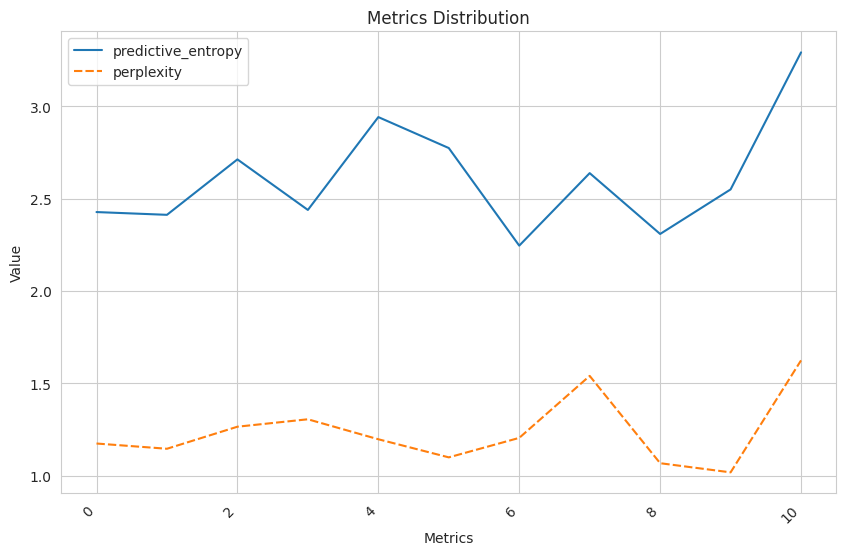

In [184]:
# plot line plot between ["predictive_entropy", "perplexity"]
import seaborn as sns
import matplotlib.pyplot as plt

df_plot = df_inferences[["predictive_entropy", "perplexity"]]
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_plot)
plt.xticks(rotation=45  , ha="right")
plt.xlabel("Metrics")
plt.ylabel("Value")
plt.title("Metrics Distribution")
plt.show()


## Summary

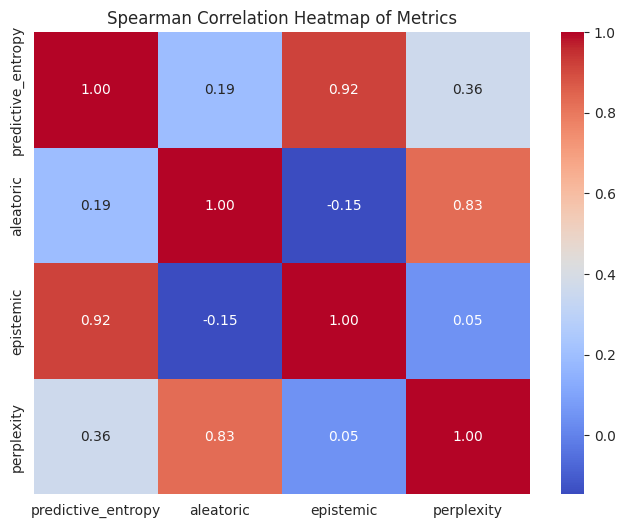

In [185]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the Spearman correlation matrix
correlation_matrix = df_inferences[["predictive_entropy", "aleatoric", "epistemic", "perplexity"]].corr(method="spearman")

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Spearman Correlation Heatmap of Metrics")
plt.show()

### Summary of Correlation Findings

Analyzing the Spearman correlation heatmap reveals the following key relationships between the uncertainty metrics (`predictive_entropy`, `aleatoric`, `epistemic`) and `perplexity`:

*   **Strong Positive Correlation between Predictive Entropy and Epistemic Uncertainty (0.92)**: This indicates a very strong direct relationship. As expected, a significant portion of the total uncertainty (predictive entropy) is driven by the model's reducible uncertainty (epistemic uncertainty).

*   **Strong Positive Correlation between Aleatoric Uncertainty and Perplexity (0.83)**: This suggests that higher data-inherent uncertainty (aleatoric uncertainty) is strongly associated with higher perplexity in the model's predictions. This implies that the model struggles more to predict tokens when the underlying data is inherently noisy or ambiguous.

*   **Low to Moderate Positive Correlation between Predictive Entropy and Perplexity (0.36)**: While there is a positive correlation, it's not as strong as the aleatoric-perplexity link, suggesting that predictive entropy is a broader measure of uncertainty that includes both reducible and irreducible components, and its relationship with perplexity is influenced by both.

*   **Very Weak Correlation between Epistemic Uncertainty and Perplexity (0.05)**: This is an interesting finding, suggesting that the model's reducible uncertainty (epistemic) does not directly correlate strongly with its perplexity in this specific context. This could mean that perplexity is more sensitive to the inherent noise in the data rather than the model's own lack of knowledge.

*   **Weak Positive Correlation between Predictive Entropy and Aleatoric Uncertainty (0.19)**:

*   **Weak Negative Correlation between Aleatoric Uncertainty and Epistemic Uncertainty (-0.15)**:

In summary, for this dataset, perplexity appears to be predominantly influenced by aleatoric uncertainty, while predictive entropy is primarily driven by epistemic uncertainty. The different uncertainty components exhibit distinct relationships with each other and with perplexity.

## Summary:

### Q&A
*   **How do the computed metrics (`predictive_entropy`, `aleatoric`, `epistemic`, and `perplexity`) relate to each other?**
    *   There is a very strong positive correlation between `predictive_entropy` and `epistemic` uncertainty (0.92), indicating that a significant portion of the total uncertainty is due to the model's reducible uncertainty.
    *   `Aleatoric` uncertainty shows a strong positive correlation with `perplexity` (0.83), suggesting that higher inherent data uncertainty is strongly associated with higher model perplexity.
    *   `Predictive_entropy` has a low to moderate positive correlation with `perplexity` (0.36).
    *   `Epistemic` uncertainty shows a very weak correlation with `perplexity` (0.05), suggesting that perplexity is not strongly influenced by the model's own reducible uncertainty.
    *   Weak positive correlation was observed between `predictive_entropy` and `aleatoric` uncertainty (0.19).
    *   A weak negative correlation exists between `aleatoric` uncertainty and `epistemic` uncertainty (-0.15).

### Data Analysis Key Findings
*   Predictive entropy is largely driven by epistemic uncertainty, evidenced by a very strong positive Spearman correlation of 0.92.
*   Perplexity is strongly correlated with aleatoric uncertainty, showing a strong positive Spearman correlation of 0.83, suggesting that higher inherent data noise leads to increased model perplexity.
*   Epistemic uncertainty has a very weak correlation with perplexity (0.05), indicating that the model's internal lack of knowledge does not directly translate to higher perplexity in this context.
*   The correlation between predictive entropy and perplexity is moderate (0.36), which is less pronounced than the aleatoric-perplexity link, reflecting its broader nature.

### Insights or Next Steps
*   The model's perplexity appears to be predominantly influenced by inherent data noise (aleatoric uncertainty) rather than the model's own knowledge gaps (epistemic uncertainty).
*   Further investigation could explore the specific data characteristics that contribute to high aleatoric uncertainty and their impact on model performance beyond perplexity.


## Hallucination detection based on LoRA Ensembles

In [187]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import get_peft_model, LoraConfig, TaskType
import numpy as np

class HallucinationDetector:
    def __init__(self, model_name, num_ensemble=5, lora_r=8):
        """
        Initialize hallucination detector with LoRA ensemble

        Args:
            model_name: HuggingFace model identifier
            num_ensemble: Number of ensemble members
            lora_r: LoRA rank
        """
        self.num_ensemble = num_ensemble
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        # Load base model
        self.base_model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            device_map="auto"
        )

        # Create LoRA ensemble
        self.ensemble = []
        for i in range(num_ensemble):
            lora_config = LoraConfig(
                r=lora_r,
                lora_alpha=16,
                target_modules=["q_proj", "v_proj"],
                lora_dropout=0.05,
                bias="none",
                task_type=TaskType.CAUSAL_LM
            )
            model = get_peft_model(self.base_model, lora_config)
            self.ensemble.append(model)

    def compute_uncertainty(self, input_text, max_length=100):
        """
        Compute uncertainty metrics for a given input

        Returns:
            dict with predictive_entropy, aleatoric, epistemic
        """
        inputs = self.tokenizer(input_text, return_tensors="pt")

        # Get predictions from each ensemble member
        all_logits = []
        all_probs = []

        for model in self.ensemble:
            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_length=max_length,
                    return_dict_in_generate=True,
                    output_scores=True
                )
                # Extract token probabilities
                logits = torch.stack(outputs.scores, dim=1)
                probs = torch.softmax(logits, dim=-1)
                all_probs.append(probs)

        # Compute uncertainty metrics
        all_probs = torch.stack(all_probs)

        # Predictive entropy (average prediction)
        mean_probs = all_probs.mean(dim=0)
        predictive_entropy = -(mean_probs * torch.log(mean_probs + 1e-10)).sum(dim=-1)

        # Aleatoric uncertainty (average of individual entropies)
        individual_entropies = -(all_probs * torch.log(all_probs + 1e-10)).sum(dim=-1)
        aleatoric = individual_entropies.mean(dim=0)

        # Epistemic uncertainty (mutual information)
        epistemic = predictive_entropy - aleatoric

        return {
            'predictive_entropy': predictive_entropy.mean().item(),
            'aleatoric': aleatoric.mean().item(),
            'epistemic': epistemic.mean().item()
        }

    def detect_hallucination(self, input_text, classifier=None, threshold=0.5):
        """
        Detect if the model is likely to hallucinate

        Args:
            input_text: Input prompt
            classifier: Pre-trained binary classifier (sklearn model)
            threshold: Decision threshold

        Returns:
            bool: True if hallucination detected
            dict: Uncertainty metrics
        """
        uncertainties = self.compute_uncertainty(input_text)

        if classifier is not None:
            # Use trained classifier
            features = np.array([[
                uncertainties['predictive_entropy'],
                uncertainties['aleatoric'],
                uncertainties['epistemic']
            ]])
            hallucination_prob = classifier.predict_proba(features)[0][1]
            is_hallucination = hallucination_prob > threshold
        else:
            # Simple threshold-based detection
            is_hallucination = uncertainties['predictive_entropy'] > threshold

        return is_hallucination, uncertainties

# Usage example
detector = HallucinationDetector("Qwen/Qwen3-0.6B" ) #"meta-llama/Llama-2-7b-hf")
is_hallucination, metrics = detector.detect_hallucination(
    "What is the capital of Mars?"
)

print(f"Hallucination detected: {is_hallucination}")
print(f"Uncertainty metrics: {metrics}")

`torch_dtype` is deprecated! Use `dtype` instead!
/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:72: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:285: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Hallucination detected: True
Uncertainty metrics: {'predictive_entropy': 1.922242522239685, 'aleatoric': 0.4471070468425751, 'epistemic': 1.4751354455947876}


**LoRA Ensemble Initialization**: The detector is initialized with a base language model (e.g., Qwen/Qwen3-0.6B) and creates multiple LoRA-adapted versions of this model. Each LoRA adapter acts as a member of an ensemble, allowing for diverse predictions while sharing the bulk of the base model's parameters.

**Uncertainty Computation**: For a given input text, the compute_uncertainty method generates responses from each LoRA ensemble member. It then collects the token-level logits and probabilities from these generations. Using these probabilities, it calculates three key uncertainty metrics:

* ***Predictive Entropy***: Measures the total uncertainty in the ensemble's average prediction.
* ***Aleatoric Uncertainty***: Quantifies the irreducible uncertainty inherent in the data itself (noise).
* ***Epistemic Uncertainty***: Represents the reducible uncertainty due to the model's own lack of knowledge or confidence, derived from the disagreement among ensemble members. This metric is particularly useful for hallucination detection, as high epistemic uncertainty can signal that the model is generating content outside its known distribution.

**Hallucination Detection**: The detect_hallucination method uses these computed uncertainty metrics. It can either employ a simple threshold-based approach (e.g., if predictive entropy exceeds a certain value) or integrate a pre-trained binary classifier that uses the uncertainty metrics as features to predict the likelihood of hallucination. This framework allows for a more robust detection of unreliable or fabricated outputs from the language model.